# Part 2: Text Preprocessing and Baseline Models

## Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re 

# settings
pd.options.display.max_colwidth = 500

## Read in data 

In [43]:
df = pd.read_csv("../data/cyberbullying_tweets.csv")

In [44]:
df.shape

(47692, 2)

# Text preprocessing 

Remove urls and usernames 

In [45]:
#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
def remove_urls (vTEXT):
    vTEXT = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', vTEXT, flags=re.MULTILINE)
    return(vTEXT)

In [46]:
#remove links 
df['no_links_text'] = [remove_urls(i) for i in df['tweet_text']]

In [47]:
# code from Devin 
Tweet = "Hello@username"
Tweet = re.sub('@[^\s]+','',Tweet)
Tweet

'Hello'

In [48]:
# remove user names and @ symbols 
df['no_links_text'] = df['no_links_text'].map(lambda x: re.sub('@[^\s]+','',x))

In [49]:
# remove ['&amp;', '&lt;&lt;&lt;']
df['no_links_text'] = df['no_links_text'].map(lambda x: re.sub("&lt;&lt;&lt;|&amp;#x200B;|&amp;", ' ', str(x))) 

In [50]:
df.tail()

,tweet_text,cyberbullying_type,no_links_text
47687,"Black ppl aren't expected to do anything, depended on for anything. Yet free to participate, work, enjoy the freedom of humans all across this globe. If you waste your energy on the past you will be wasting it for building the future.",ethnicity,"Black ppl aren't expected to do anything, depended on for anything. Yet free to participate, work, enjoy the freedom of humans all across this globe. If you waste your energy on the past you will be wasting it for building the future."
47688,Turner did not withhold his disappointment. Turner called the court an “abominable conclave of negro hating demons” (with one exception) who “issued another decree that colored men and women must be driven into Jim Crow cars whenever it suits the whim of any white community.”,ethnicity,Turner did not withhold his disappointment. Turner called the court an “abominable conclave of negro hating demons” (with one exception) who “issued another decree that colored men and women must be driven into Jim Crow cars whenever it suits the whim of any white community.”
47689,I swear to God. This dumb nigger bitch. I have got to bleach my hair reeeeeal fuckin' soon. D:&lt; FUCK.,ethnicity,I swear to God. This dumb nigger bitch. I have got to bleach my hair reeeeeal fuckin' soon. D:&lt; FUCK.
47690,"Yea fuck you RT @therealexel: IF YOURE A NIGGER FUCKING UNFOLLOW ME, FUCKING DUMB NIGGERS.",ethnicity,"Yea fuck you RT IF YOURE A NIGGER FUCKING UNFOLLOW ME, FUCKING DUMB NIGGERS."
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK KP that dumb nigger bitch lmao,ethnicity,Bro. U gotta chill RT Dog FUCK KP that dumb nigger bitch lmao


## Export preprocessed dataframe to csv

In [59]:
df.to_csv('../data/cleaned_tweets.csv', index=False)

## Create 10% sample dataframe for modeling 

In [65]:
df_sample = df.sample(4800, random_state=42)
df_sample.head(1)

,tweet_text,cyberbullying_type,no_links_text
40362,"@Goree_JuhssGuns hahaha he ain't even worth my tweets dumb fuck don't knw the diff between ""nigga"" &amp; ""nigger""",ethnicity,"hahaha he ain't even worth my tweets dumb fuck don't knw the diff between ""nigga"" ""nigger"""


In [20]:
df_sample.tail(1)

,tweet_text,cyberbullying_type,no_links_text
28463,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR",other_cyberbullying,"Yes, we get it. You're pretty. Tone down the self promo and just cook! @mykitchenrules #MKR"


In [58]:
df_sample.to_csv('../data/cleaned_tweets_sample.csv', index=False)

# Modeling

## Classifier pipelines

Compare text vectorizing methods count vectorizer and term frequency inverse document frequency using logistic regression and naive bayes

In [125]:
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split 

from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, classification_report

In [66]:
df = df_sample
df.shape

(4800, 3)

### Train test split

In [67]:
y = df['cyberbullying_type']
X = df['no_links_text']

In [68]:
X.shape

(4800,)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Count vectorizer

In [82]:
cv_log = Pipeline([
    ('cv', CountVectorizer(min_df=3)), 
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
]) 

cv_log.fit(X_train, y_train)
cv_log.score(X_train, y_train), cv_log.score(X_test, y_test)

(0.9677777777777777, 0.7816666666666666)

In [81]:
cv_mnb = Pipeline([
    ('cv', CountVectorizer(min_df=3)), 
    ('mnb', MultinomialNB())
]) 

cv_mnb.fit(X_train, y_train)
cv_mnb.score(X_train, y_train), cv_mnb.score(X_test, y_test)

(0.8575, 0.7333333333333333)

### TF-IDF 

In [78]:
tf_log = Pipeline([
    ('tf', TfidfVectorizer(min_df=3)), 
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs'))
])

tf_log.fit(X_train, y_train)
tf_log.score(X_train, y_train), tf_log.score(X_test, y_test)

(0.9163888888888889, 0.7883333333333333)

In [80]:
tf_mnb = Pipeline([
    ('tf', TfidfVectorizer(min_df=3)), 
    ('mnb', MultinomialNB())
])

tf_mnb.fit(X_train, y_train)
tf_mnb.score(X_train, y_train), tf_mnb.score(X_test, y_test)

(0.8563888888888889, 0.7083333333333334)

## Evaluate classifier models

In [163]:
def classifier_metrics(pipeline_list, X_test, y_test):
    
    for model in pipeline_list:
        preds = model.predict(X_test)
        print(f'Accuracy = {round(accuracy_score(y_test, preds), 4)}')
        fig, ax = plt.subplots(figsize=(5, 5))
        plot_confusion_matrix(model, X_test, y_test, cmap='Blues', ax=ax, xticks_rotation=45, colorbar=False)
        plt.title({model})
        plt.show(); 
        # print(classification_report(y_test, preds))
        print()

    return

Accuracy = 0.7817


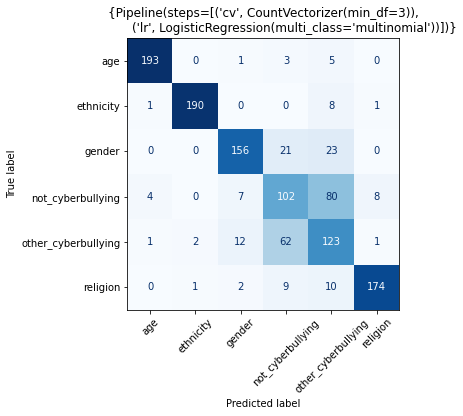


Accuracy = 0.7333


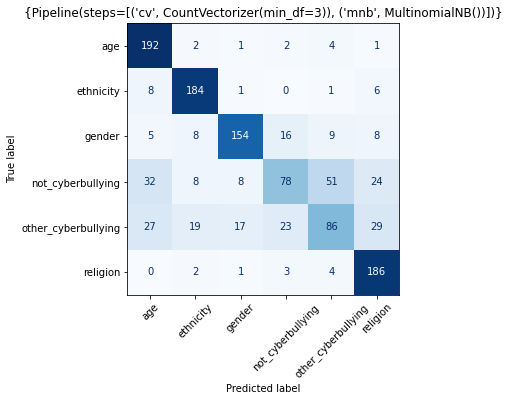


Accuracy = 0.7883


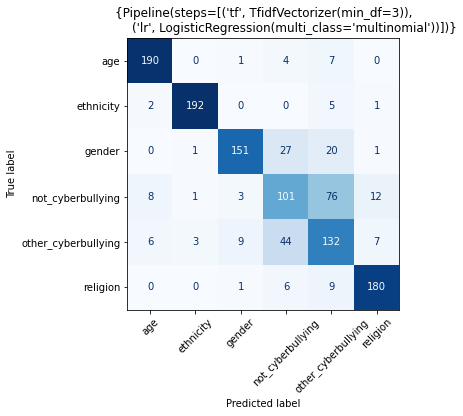


Accuracy = 0.7083


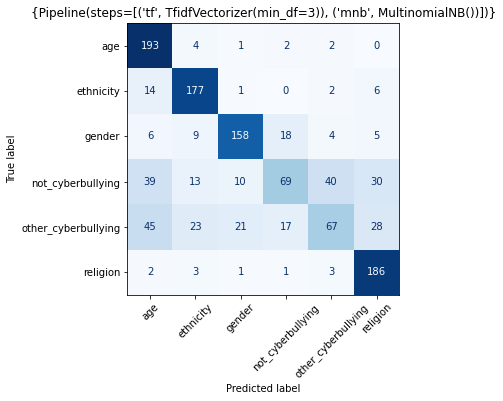

In [164]:
classifier_metrics([cv_log, cv_mnb, tf_log, tf_mnb], X_test, y_test)

## Neural net sentence transformer and cosine similarities

### SBERT 

Install: pip install -U sentence-transformers

Citation  Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks (2019)

Transorm text with SBERT (SentenceTransformer) and compute cosine similarities for each tweet

### Example from SBERT documentation

In [173]:
# example code from https://www.sbert.net/docs/usage/semantic_textual_similarity.html 

from sentence_transformers import SentenceTransformer, util

In [173]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Two lists of sentences
sentences1 = ['The cat sits outside',
             'A man is playing guitar',
             'The new movie is awesome']

sentences2 = ['The dog plays in the garden',
              'A woman watches TV',
              'The new movie is so great']

#Compute embedding for both lists
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

#Compute cosine-similarits
cosine_scores = util.cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(len(sentences1)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_scores[i][i]))

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

The cat sits outside 		 The dog plays in the garden 		 Score: 0.2838
A man is playing guitar 		 A woman watches TV 		 Score: -0.0327
The new movie is awesome 		 The new movie is so great 		 Score: 0.8939


### Compare tweets labeled 'gender' with each other 
Test sbert with 4 sentences from corpus

In [207]:
# lists of sentences that are similar 
sentences1 = [each for each in gender_df['no_links_text'][:2]]
sentences2 = [each for each in gender_df['no_links_text'][3:5]]

In [208]:
sentences1

['RT  Sucks to have the smile wiped off your own face huh Kat? She in a glass house should not throw stones. #mkr  #mkr2015',
 "things that AREN'T jokes - rape - sexism - racism - suicide - self harm - Mariah Carey hate - gay as an insult - mental illness"]

In [209]:
sentences2

['RT   that a female referee? Not sexist but...  They are only for camps right? This will not be happening in the regu…',
 'men when they think saying any slur making racist jokes “retard” “gay” any rape joke think they so tough. also men when we say they are not funny']

In [210]:
# instantiate model 
sbert_cos = SentenceTransformer('all-MiniLM-L6-v2')

# compute embedding for both lists 
embeddings1 = sbert_cos.encode(sentences1, convert_to_tensor=True)
embeddings2 = sbert_cos.encode(sentences2, convert_to_tensor=True)

# compute cosine-similarities 
cosine_scores = util.cos_sim(embeddings1, embeddings2)

In [213]:
#Output the pairs with their score
for i in range(len(sentences1)):
    # print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_scores[i][i]))
    print(cosine_scores[i][i])

tensor(0.1512)
tensor(0.4775)


### SBERT and cosine similarities scaled up 